In [1]:
!pip install git+https://github.com/rcmalli/keras-vggface
!pip install keras_applications
!pip install keras-dtensor
!pip install mtcnn
!pip uninstall keras
!pip install keras==2.12

  Cloning https://github.com/rcmalli/keras-vggface to /tmp/pip-req-build-mszz_oer
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface /tmp/pip-req-build-mszz_oer
  Resolved https://github.com/rcmalli/keras-vggface to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement keras-dtensor (from versions: none)
ERROR: No matching distribution found for keras-dtensor
Found existing installation: keras 2.12.0
Uninstalling keras-2.12.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-2.12.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? Y
  Successfully uninstalled keras-2.12.0
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

In [2]:
import tensorflow as tf
import keras
import keras_vggface
from keras_vggface.vggface import VGGFace
import mtcnn
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.data_utils import get_file
import keras_vggface.utils
import PIL
import os
import os.path
import zipfile

In [3]:
zip_ref = zipfile.ZipFile ('/content/Dog&Cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
train_dataset = keras.utils.image_dataset_from_directory('/content/Dog&Cats',
                                                        shuffle = True,
                                                        batch_size = 9,
                                                        image_size = (224, 224))


Found 146 files belonging to 2 classes.


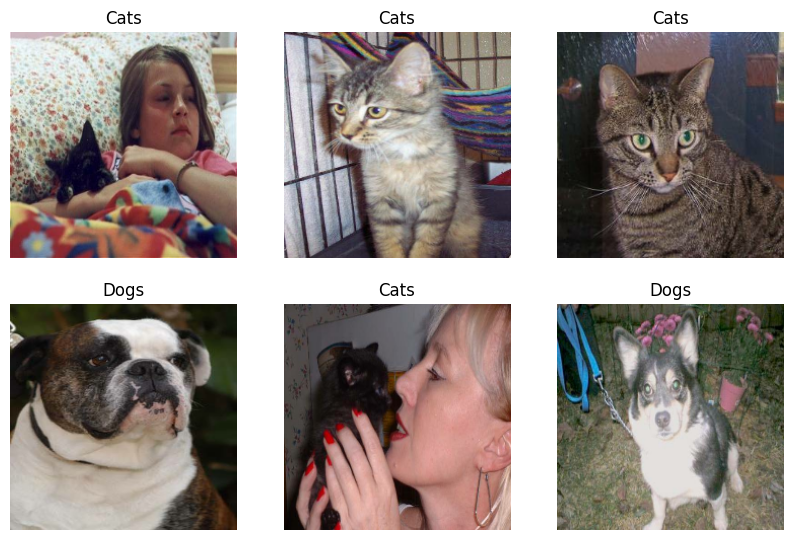

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(6):
    ax = plt.subplot(3,3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),

])

In [10]:
vggface_resnet_base = VGGFace(model='resnet50', include_top=False, input_shape=(224,224,3))

94694792/94694792 [==============================] - 1s 0us/step


In [11]:
from keras.layers import Flatten, Dense, Input

nb_class = 1


vggface_resnet_base.trainable=False


inputs = tf.keras.Input(shape=(224,224,3))

x = data_augmentation(inputs)

x = vggface_resnet_base(x)

x = Flatten(name='flatten')(x)

out = Dense(nb_class, name='classifier')(x)

model = keras.Model(inputs, out)

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
initial_epochs = 20

history = model.fit(train_dataset, epochs=initial_epochs)

Epoch 1/20
17/17 [==============================] - 11s 108ms/step - loss: 0.7352 - accuracy: 0.5000
Epoch 2/20
17/17 [==============================] - 1s 34ms/step - loss: 0.6796 - accuracy: 0.5548
Epoch 3/20
17/17 [==============================] - 1s 34ms/step - loss: 0.7101 - accuracy: 0.5342
Epoch 4/20
17/17 [==============================] - 1s 34ms/step - loss: 0.7074 - accuracy: 0.5342
Epoch 5/20
17/17 [==============================] - 1s 34ms/step - loss: 0.6934 - accuracy: 0.5342
Epoch 6/20
17/17 [==============================] - 1s 34ms/step - loss: 0.6732 - accuracy: 0.5753
Epoch 7/20
17/17 [==============================] - 1s 33ms/step - loss: 0.6587 - accuracy: 0.5479
Epoch 8/20
17/17 [==============================] - 1s 33ms/step - loss: 0.6927 - accuracy: 0.5205
Epoch 9/20
17/17 [==============================] - 1s 37ms/step - loss: 0.6481 - accuracy: 0.5890
Epoch 10/20
17/17 [==============================] - 1s 37ms/step - loss: 0.6695 - accuracy: 0.5616
Epoch 1

Predictions:
 [0 1 1 1 0 0 0 1 1]
Labels:
 [1 0 1 0 0 1 0 1 0]


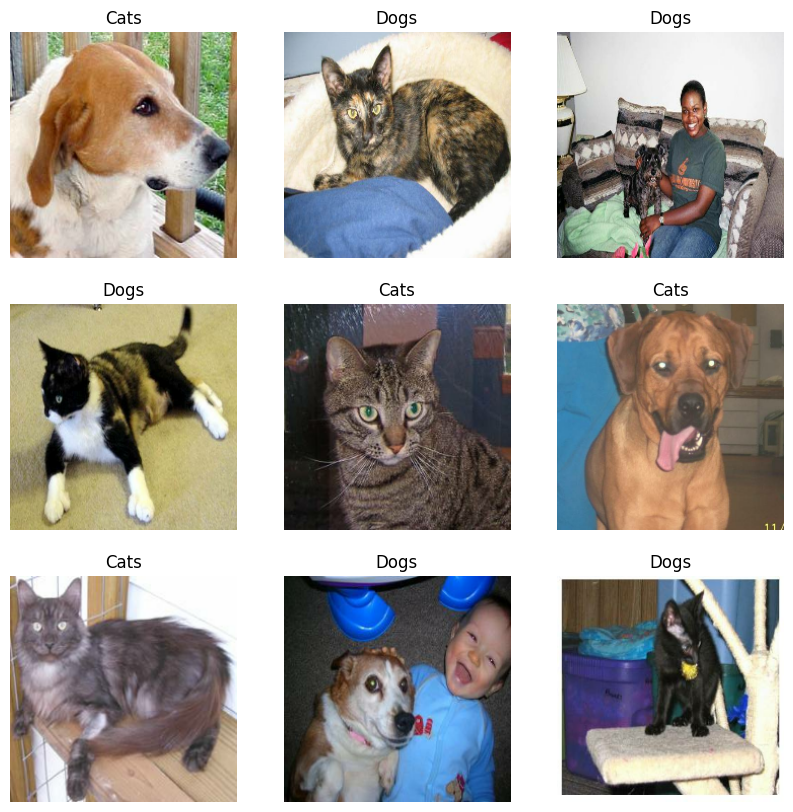

In [16]:
image_batch, label_batch = train_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()


predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")